In [19]:
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import nn
import torchvision.models as models
import torch.optim as optim
from sklearn.metrics import ConfusionMatrixDisplay
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [20]:
import os
print(os.listdir('/kaggle/input'))

['train_split_2_Y.csv', 'valid_split_2_X.csv', 'train_split_2_X.csv', 'valid_split_2_Y.csv', 'test_split_2_X.csv', 'train_features', 'test_split_2_Y.csv', 'train_labels.csv', 'train_features.csv', 'test_features.csv', 'test_features']


In [21]:
train_features = pd.read_csv("/kaggle/input/train_features.csv", index_col="id")
test_features = pd.read_csv("/kaggle/input/test_features.csv", index_col="id")
train_labels = pd.read_csv("/kaggle/input/train_labels.csv", index_col="id")

In [22]:
count = 0
for i in train_labels.columns:
    number_of_samples = len(train_labels[train_labels[i]==1.0])
    print(i,"has total samples-->",number_of_samples)
    count = count + number_of_samples
print("Total Samples-->",count)

antelope_duiker has total samples--> 2474
bird has total samples--> 1641
blank has total samples--> 2213
civet_genet has total samples--> 2423
hog has total samples--> 978
leopard has total samples--> 2254
monkey_prosimian has total samples--> 2492
rodent has total samples--> 2013
Total Samples--> 16488


## **Dataset Splitting**

In [23]:
frac=1.0
y = train_labels.sample(frac=frac, random_state=1)
x = train_features.loc[y.index].filepath.to_frame()

# Dataset Splitting Into Train-Eval-Test
x_train, x_temp, y_train, y_temp = train_test_split(x, y, stratify=y, test_size=0.2)
x_test, x_eval, y_test, y_eval = train_test_split(x_temp, y_temp, stratify=y_temp, test_size=0.5)

In [24]:
print("Length of Train Set is-->",x_train.shape[0],
      " and Percentage is: ",round((x_train.shape[0]/x.shape[0])*100),"%")
print("Length of Test Set is-->",x_test.shape[0],
      " and Percentage is:   ",round((x_test.shape[0]/x.shape[0])*100),"%")
print("Length of Evaluation Set is-->",
      x_eval.shape[0]," and Percentage is:  ",round((x_eval.shape[0]/x.shape[0])*100),"%")

Length of Train Set is--> 13190  and Percentage is:  80 %
Length of Test Set is--> 1649  and Percentage is:    10 %
Length of Evaluation Set is--> 1649  and Percentage is:   10 %


## **Dataset Formatting**

In [25]:
class ConserImagesDataset(Dataset):
    def __init__(self, x_df, y_df=None):#,data_set='train'
        self.data = x_df
        self.label = y_df
        # self.data_set = data_set
        self.transform = transforms.Compose(
            [
                transforms.Resize((64, 64)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
            ]
        )

    def __getitem__(self, index):

        base_path = '/kaggle/input/train_features/' 
        data_path = base_path+self.data.iloc[index]["filepath"]
        image = Image.open(data_path).convert("RGB")
        image = self.transform(image)
        image_id = self.data.index[index]
        
        if self.label is None:
            sample = {"image_id": image_id, "image": image}
        else:
            label = torch.tensor(self.label.iloc[index].values, 
                                 dtype=torch.float)
            sample = {"image_id": image_id, "image": image, "label": label}
        return sample

    def __len__(self):
        return len(self.data)

In [26]:
train_dataset = ConserImagesDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32)

## **Model**

In [27]:
# Loading VGG16 model
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

model.classifier = nn.Sequential(
    nn.Linear(25088, 100), 
    nn.ReLU(inplace=True),  
    nn.Dropout(0.1),  
    nn.Linear(100, 8),
)

#Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [28]:
num_epochs = 2

tracking_loss = {}

for epoch in range(1, num_epochs + 1):
    print(f"Starting epoch {epoch}")

    # iterate through the dataloader batches. tqdm keeps track of progress.
    for batch_n, batch in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):

        # 1) zero out the parameter gradients so that gradients from previous batches are not used in this step
        optimizer.zero_grad()

        # 2) run the foward step on this batch of images
        outputs = model(batch["image"])

        # 3) compute the loss
        loss = criterion(outputs, batch["label"])
        # let's keep track of the loss by epoch and batch
        tracking_loss[(epoch, batch_n)] = float(loss)

        # 4) compute our gradients
        loss.backward()
        # update our weights
        optimizer.step()

Starting epoch 1


100%|██████████| 413/413 [10:55<00:00,  1.59s/it]


Starting epoch 2


100%|██████████| 413/413 [10:30<00:00,  1.53s/it]


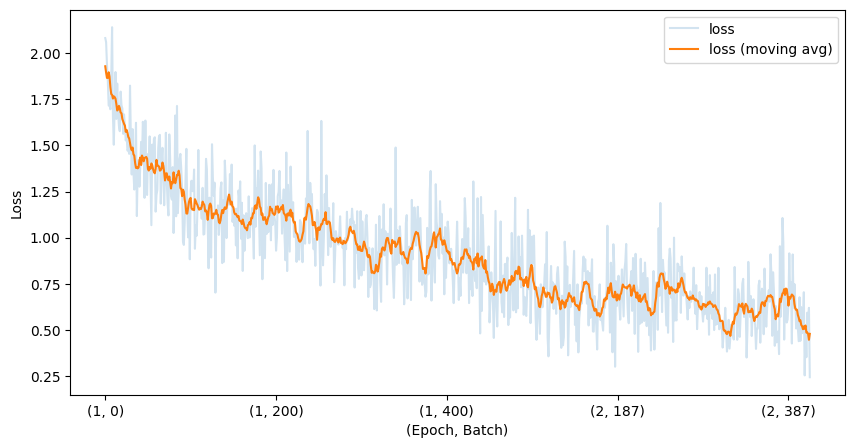

In [29]:
tracking_loss = pd.Series(tracking_loss)

plt.figure(figsize=(10, 5))
tracking_loss.plot(alpha=0.2, label="loss")
tracking_loss.rolling(center=True, min_periods=1, window=10).mean().plot(
    label="loss (moving avg)"
)
plt.xlabel("(Epoch, Batch)")
plt.ylabel("Loss")
plt.legend(loc=0)

In [30]:
torch.save(model, "model.pth")

In [31]:
eval_dataset = ConserImagesDataset(x_eval, y_eval)
eval_dataloader = DataLoader(eval_dataset, batch_size=32)

preds_collector = []

# put the model in eval mode so we don't update any parameters
model.eval()

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch in tqdm(eval_dataloader, total=len(eval_dataloader)):
        # 1) run the forward step
        logits = model.forward(batch["image"])
        # 2) apply softmax so that model outputs are in range [0,1]
        preds = nn.functional.softmax(logits, dim=1)
        # 3) store this batch's predictions in df
        # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
        preds_df = pd.DataFrame(
            preds.detach().numpy(),
            index=batch["image_id"],
            
        )
        preds_collector.append(preds_df)

eval_preds_df = pd.concat(preds_collector)

100%|██████████| 52/52 [00:36<00:00,  1.43it/s]


In [32]:
eval_preds_df

,0,1,2,3,4,5,6,7
ZJ004396,0.046458,2.781897e-03,0.054012,2.810420e-05,0.000352,0.000024,0.882067,1.427725e-02
ZJ002957,0.005864,8.935051e-04,0.036330,8.023840e-02,0.000454,0.000049,0.000288,8.758827e-01
ZJ012450,0.000246,5.703362e-08,0.001167,6.732122e-08,0.000068,0.998511,0.000008,9.777707e-08
ZJ012527,0.502727,2.297757e-03,0.220307,8.368187e-05,0.000114,0.000060,0.264648,9.762535e-03
ZJ009187,0.000320,1.778255e-04,0.064605,5.895700e-05,0.000208,0.934355,0.000051,2.233924e-04
...,...,...,...,...,...,...,...,...
ZJ012045,0.033188,4.810356e-03,0.067250,1.120014e-04,0.000351,0.000927,0.876672,1.668923e-02
ZJ002748,0.019017,4.847032e-04,0.040467,9.198262e-01,0.000049,0.000162,0.000032,1.996252e-02
ZJ008412,0.011455,1.081098e-03,0.009215,1.483940e-06,0.000140,0.000022,0.977908,1.765997e-04
ZJ005695,0.002198,5.383538e-05,0.022422,9.522418e-01,0.000150,0.000149,0.000013,2.277299e-02


In [33]:
y_train.idxmax(axis=1).value_counts()

monkey_prosimian    1994
antelope_duiker     1979
civet_genet         1938
leopard             1803
blank               1770
rodent              1610
bird                1313
hog                  783
Name: count, dtype: int64

In [34]:
print("True labels (training):")
print(y_train.idxmax(axis=1).value_counts())

print("Predicted labels (eval):")
print(eval_preds_df.idxmax(axis=1).value_counts())

print("True labels (eval):")
print(y_eval.idxmax(axis=1).value_counts())

print("Prediction on Evaluation Set")
eval_predictions = eval_preds_df.idxmax(axis=1)
eval_predictions.head()

eval_true = y_eval.idxmax(axis=1)

(eval_true == "monkey_prosimian").sum() / len(eval_predictions)

correct = (eval_predictions == eval_true).sum()
accuracy = correct / len(eval_predictions)
accuracy

True labels (training):
monkey_prosimian    1994
antelope_duiker     1979
civet_genet         1938
leopard             1803
blank               1770
rodent              1610
bird                1313
hog                  783
Name: count, dtype: int64
Predicted labels (eval):
6    338
3    281
0    214
5    213
2    201
7    187
1    129
4     86
Name: count, dtype: int64
True labels (eval):
monkey_prosimian    249
antelope_duiker     248
civet_genet         243
leopard             225
blank               222
rodent              201
bird                164
hog                  97
Name: count, dtype: int64
Prediction on Evaluation Set


0.0

In [35]:
eval_true

id
ZJ004396    monkey_prosimian
ZJ002957              rodent
ZJ012450             leopard
ZJ012527    monkey_prosimian
ZJ009187             leopard
                  ...       
ZJ012045    monkey_prosimian
ZJ002748         civet_genet
ZJ008412    monkey_prosimian
ZJ005695         civet_genet
ZJ000854         civet_genet
Length: 1649, dtype: object